# Test Model Notebook
Bu dosya eğitilen modelleri yükler ve test seti üzerinde değerlendirme yapar.

In [2]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack

In [3]:
# Veri seti yükleme ve temizleme
df = pd.read_csv("data/fake_reviews_dataset.csv")
df.rename(columns={"text_": "review"}, inplace=True)
df["review"] = df["review"].astype(str)

df['label'] = df['label'].map({'CG': 0, 'OR': 1})
df = df.rename(columns={'text_': 'review'})
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text
df['clean_review'] = df['review'].apply(clean_text)
df['review_length'] = df['review'].apply(lambda x: len(str(x)))
df['exclamation_count'] = df['review'].apply(lambda x: str(x).count('!'))
df['capital_word_ratio'] = df['review'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]) / (len(str(x).split()) + 1e-5))

In [4]:

# TF-IDF vektörleştiriciyi yükle
tfidf = joblib.load('models/tfidf_vectorizer.pkl')

# TF-IDF transform (fit yapılmaz!)
X_tfidf = tfidf.transform(df['clean_review'])


In [5]:

# Eğitimde kaydedilen test verilerini yükle
X_test = joblib.load('models/X_test_combined.pkl')
y_test = joblib.load('models/y_test_labels.pkl')


In [6]:

# Eğitimde kaydedilen LSTM test verilerini yükle
#X_test_lstm = joblib.load("models/X_test_lstm.pkl")
#y_test_lstm = joblib.load("models/y_test_lstm.pkl")


In [7]:

# Tokenizer ve test verisini yükle
#tokenizer = joblib.load("models/lstm_tokenizer.pkl")
#X_test_lstm = joblib.load("models/X_test_lstm.pkl")
#y_test_lstm = joblib.load("models/y_test_lstm.pkl")


C:\Users\kayra\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Sistem belirtilen dosyayı bulamıyor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kayra\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kayra\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kayra\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kayra\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       804
           1       0.88      0.92      0.90       814

    accuracy                           0.90      1618
   macro avg       0.90      0.90      0.90      1618
weighted avg       0.90      0.90      0.90      1618

ROC-AUC: 0.9694968034520274


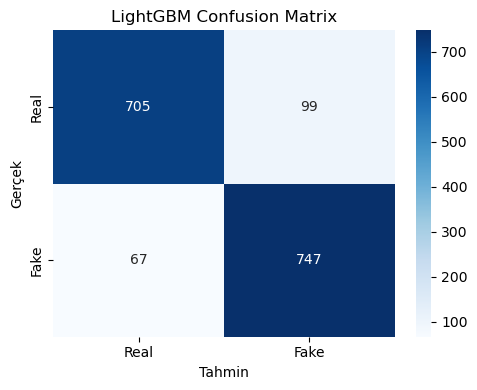

In [8]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Modeli yükle
lgb_model = joblib.load("models/lightgbm_model.pkl")
y_pred_lgb = lgb_model.predict(X_test.toarray())
y_prob_lgb = lgb_model.predict_proba(X_test.toarray())[:, 1]

print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))

# Confusion Matrix
conf = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(5, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("LightGBM Confusion Matrix")
plt.tight_layout()
plt.savefig("plots/lightgbm_confusion_matrix_2nd_dataset.png")


In [9]:
# [Yorumlandı - yanlış kullanım]
# # Özellik çıkarımı ve veri ayırma
# tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
# X_tfidf = tfidf.fit_transform(df['clean_review'])
# X_numeric = df[['review_length', 'exclamation_count', 'capital_word_ratio']].values
# X_combined = hstack([X_tfidf, X_numeric])
# y = df['label'].values
# X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Modeli yükle ve test et
nb_model = joblib.load('models/naive_bayes_model.pkl')
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       804
           1       0.84      0.81      0.83       814

    accuracy                           0.83      1618
   macro avg       0.83      0.83      0.83      1618
weighted avg       0.83      0.83      0.83      1618



In [11]:
import joblib
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# Model dosyalarının yolu (klasör adı farklıysa değiştir)
model_dir = "models/"

# Tüm modelleri yükle
naive_bayes = joblib.load(model_dir + "naive_bayes_model.pkl")
svm = joblib.load(model_dir + "svm_model.pkl")
lgbm = joblib.load(model_dir + "lightgbm_model.pkl")
mlp = joblib.load(model_dir + "mlp_model.pkl")
tfidf = joblib.load(model_dir + "tfidf_vectorizer.pkl")
X_test = joblib.load(model_dir + "X_test_combined.pkl")
y_test = joblib.load(model_dir + "y_test_labels.pkl")

# Modelleri test et ve sonuçları yazdır
models = {
    "Naive Bayes": naive_bayes,
    "SVM": svm,
    "LightGBM": lgbm,
    "MLP": mlp
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"==== {name} ====")
    print(classification_report(y_test, y_pred, digits=4))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


==== Naive Bayes ====
              precision    recall  f1-score   support

           0     0.8131    0.8495    0.8309       804
           1     0.8445    0.8071    0.8254       814

    accuracy                         0.8282      1618
   macro avg     0.8288    0.8283    0.8281      1618
weighted avg     0.8289    0.8282    0.8281      1618

Accuracy: 0.8281829419035847
F1 Score: 0.8253768844221105
Confusion Matrix:
 [[683 121]
 [157 657]]


==== SVM ====
              precision    recall  f1-score   support

           0     0.8989    0.8843    0.8915       804
           1     0.8875    0.9017    0.8946       814

    accuracy                         0.8931      1618
   macro avg     0.8932    0.8930    0.8931      1618
weighted avg     0.8932    0.8931    0.8931      1618

Accuracy: 0.8930778739184178
F1 Score: 0.894576477757465
Confusion Matrix:
 [[711  93]
 [ 80 734]]


==== LightGBM ====
              precision    recall  f1-score   support

           0     0.9132    0.8769